<a href="https://colab.research.google.com/github/JonasRiber/object_detection_YOLO/blob/main/notebooks/object_detection_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Object detection using YOLO

Goal: detect multiple objects in an image

Data: subset of COCO

#### Setup

In [70]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import os

#### Hyperparameters

In [71]:
train_split_ratio = 0.8 # for train/val split
epochs = 30
batch_size = 16
run_version = "run1"


### Initial Data Handling




In [72]:
# Install Ultralytics YOLO library
%pip install ultralytics

# Define the path to store the dataset
dataset_path = '/content/coco128'

# Check if the dataset directory already exists
if not os.path.exists(dataset_path):
  # Download the COCO128 dataset (a small subset of COCO)
  print("Downloading COCO128 dataset...")
  !curl -L "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip" -o coco128.zip
  !unzip -q coco128.zip -d /content/
  !rm coco128.zip
  print("Download complete.")
else:
  print("COCO128 dataset already exists.")

COCO128 dataset already exists.


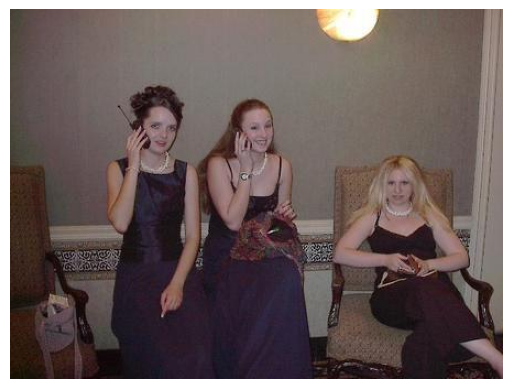

In [73]:
# Define the path to the images
image_dir = '/content/coco128/images/train2017'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Select the first image
if image_files:
    img_path = os.path.join(image_dir, image_files[0])
    img = Image.open(img_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("No images found in the specified directory.")

## Split data

Prepping for model training requires a training and a test split of the dataset.

Define paths for training and validation directories, create these directories if they don't exist, list image files, split them into train and validation sets, and copy the files to the respective directories.


In [74]:
import shutil
import random

# Define paths for original and split datasets
original_image_dir = '/content/coco128/images/train2017'
original_label_dir = '/content/coco128/labels/train2017'

train_image_dir = '/content/coco128_split/images/train2017'
train_label_dir = '/content/coco128_split/labels/train2017'
val_image_dir = '/content/coco128_split/images/val2017'
val_label_dir = '/content/coco128_split/labels/val2017'

# Create directories if they don't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# List all image files
all_image_files = [f for f in os.listdir(original_image_dir) if f.endswith('.jpg')]
random.shuffle(all_image_files) # Shuffle the list of images

# Determine the number of images for training
train_count = int(len(all_image_files) * train_split_ratio)

# Split image files into training and validation sets
train_image_files = all_image_files[:train_count]
val_image_files = all_image_files[train_count:]

# Function to copy files
def copy_files(image_list, source_image_dir, source_label_dir, dest_image_dir, dest_label_dir):
    for image_file in image_list:
        # Copy image file
        shutil.copy(os.path.join(source_image_dir, image_file), dest_image_dir)

        # Copy corresponding label file
        label_file = image_file.replace('.jpg', '.txt')
        source_label_path = os.path.join(source_label_dir, label_file)
        dest_label_path = os.path.join(dest_label_dir, label_file)

        # Check if label file exists before copying
        if os.path.exists(source_label_path):
            shutil.copy(source_label_path, dest_label_dir)
        else:
            print(f"Warning: Label file not found for {image_file}. Skipping.")


# Copy files to train and validation directories
copy_files(train_image_files, original_image_dir, original_label_dir, train_image_dir, train_label_dir)
copy_files(val_image_files, original_image_dir, original_label_dir, val_image_dir, val_label_dir)

print(f"Split complete. {len(train_image_files)} images in training set, {len(val_image_files)} images in validation set.")


Split complete. 102 images in training set, 26 images in validation set.


## Configure yolo

Create the coco128.yaml file and write the configuration content into it as specified in the instructions.

For now we use all the classes found within the dataset, later if determined that some are problematic or uninteresting they would have to be filtered out.


In [75]:
import yaml

# Define the configuration data
config = {
    'train': '/content/coco128_split/images/train2017',
    'val': '/content/coco128_split/images/val2017',
    'nc': 80,
    'names': ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
              'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
              'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
              'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
              'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
              'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
              'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
              'hair drier', 'toothbrush']
}

# Define the path for the YAML file
yaml_file_path = '/content/coco128.yaml'

# Write the configuration to the YAML file
with open(yaml_file_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=None)

print(f"Configuration file '{yaml_file_path}' created successfully.")

# Optional: Display the content of the created file to verify
with open(yaml_file_path, 'r') as f:
    print("\nContent of coco128.yaml:")
    print(f.read())

Configuration file '/content/coco128.yaml' created successfully.

Content of coco128.yaml:
names: [person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic
    light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep,
  cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase,
  frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard,
  surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana,
  apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch,
  potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell
    phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors,
  teddy bear, hair drier, toothbrush]
nc: 80
train: /content/coco128_split/images/train2017
val: /content/coco128_split/images/val2017



## Train the YOLO model

Train the YOLO model using the configuration file created in the previous step.


In [76]:
from ultralytics import YOLO

# Load a pre-trained YOLO model
model = YOLO('yolov8n.pt')

# Define the results directory
results_dir = '/content/yolo_training_results'

# Train the model
results = model.train(data='/content/coco128.yaml',
                      epochs=epochs,
                      batch=batch_size,
                      plots=True,
                      project=results_dir, name=run_version, exist_ok=True)

New https://pypi.org/project/ultralytics/8.3.197 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.196 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run1, nbs=64, nms=False, opset=None, optim

## Evaluate model


Evaluate the trained model on the validation set.

YOLO comes with an evaluation function in the `val()` method.


In [77]:
metrics = model.val(data='/content/coco128.yaml')
print(metrics)

Ultralytics 8.3.196 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 895.8±122.1 MB/s, size: 62.1 KB)
val: Scanning /content/coco128_split/labels/val2017.cache... 103 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 104/104 91.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 0.3it/s 26.5s
                   all        104        678      0.761      0.733      0.801      0.634
                person         49        193       0.84       0.72      0.811      0.589
               bicycle          2          3      0.723      0.667      0.666        0.6
                   car         11         45      0.809      0.282      0.495      0.262
            motorcycle          3          4      0.767       0.75      0.912      0.805
              airplane          5       

In [78]:
# Extract key metrics
precision = metrics.box.p.mean() # Calculate mean for overall precision
recall = metrics.box.r.mean() # Calculate mean for overall recall
map50 = metrics.box.map50
map = metrics.box.map

print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall mAP50: {map50:.4f}")
print(f"Overall mAP50-95: {map:.4f}")

Overall Precision: 0.7610
Overall Recall: 0.7333
Overall mAP50: 0.8010
Overall mAP50-95: 0.6341


### Performance Visualization

In [79]:
!ls /content/yolo_training_results/{run_version}/

args.yaml			 results.csv	     val_batch0_labels.jpg
BoxF1_curve.png			 results.png	     val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg    val_batch1_labels.jpg
BoxPR_curve.png			 train_batch160.jpg  val_batch1_pred.jpg
BoxR_curve.png			 train_batch161.jpg  val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch162.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch1.jpg    weights
labels.jpg			 train_batch2.jpg


Training Plots:


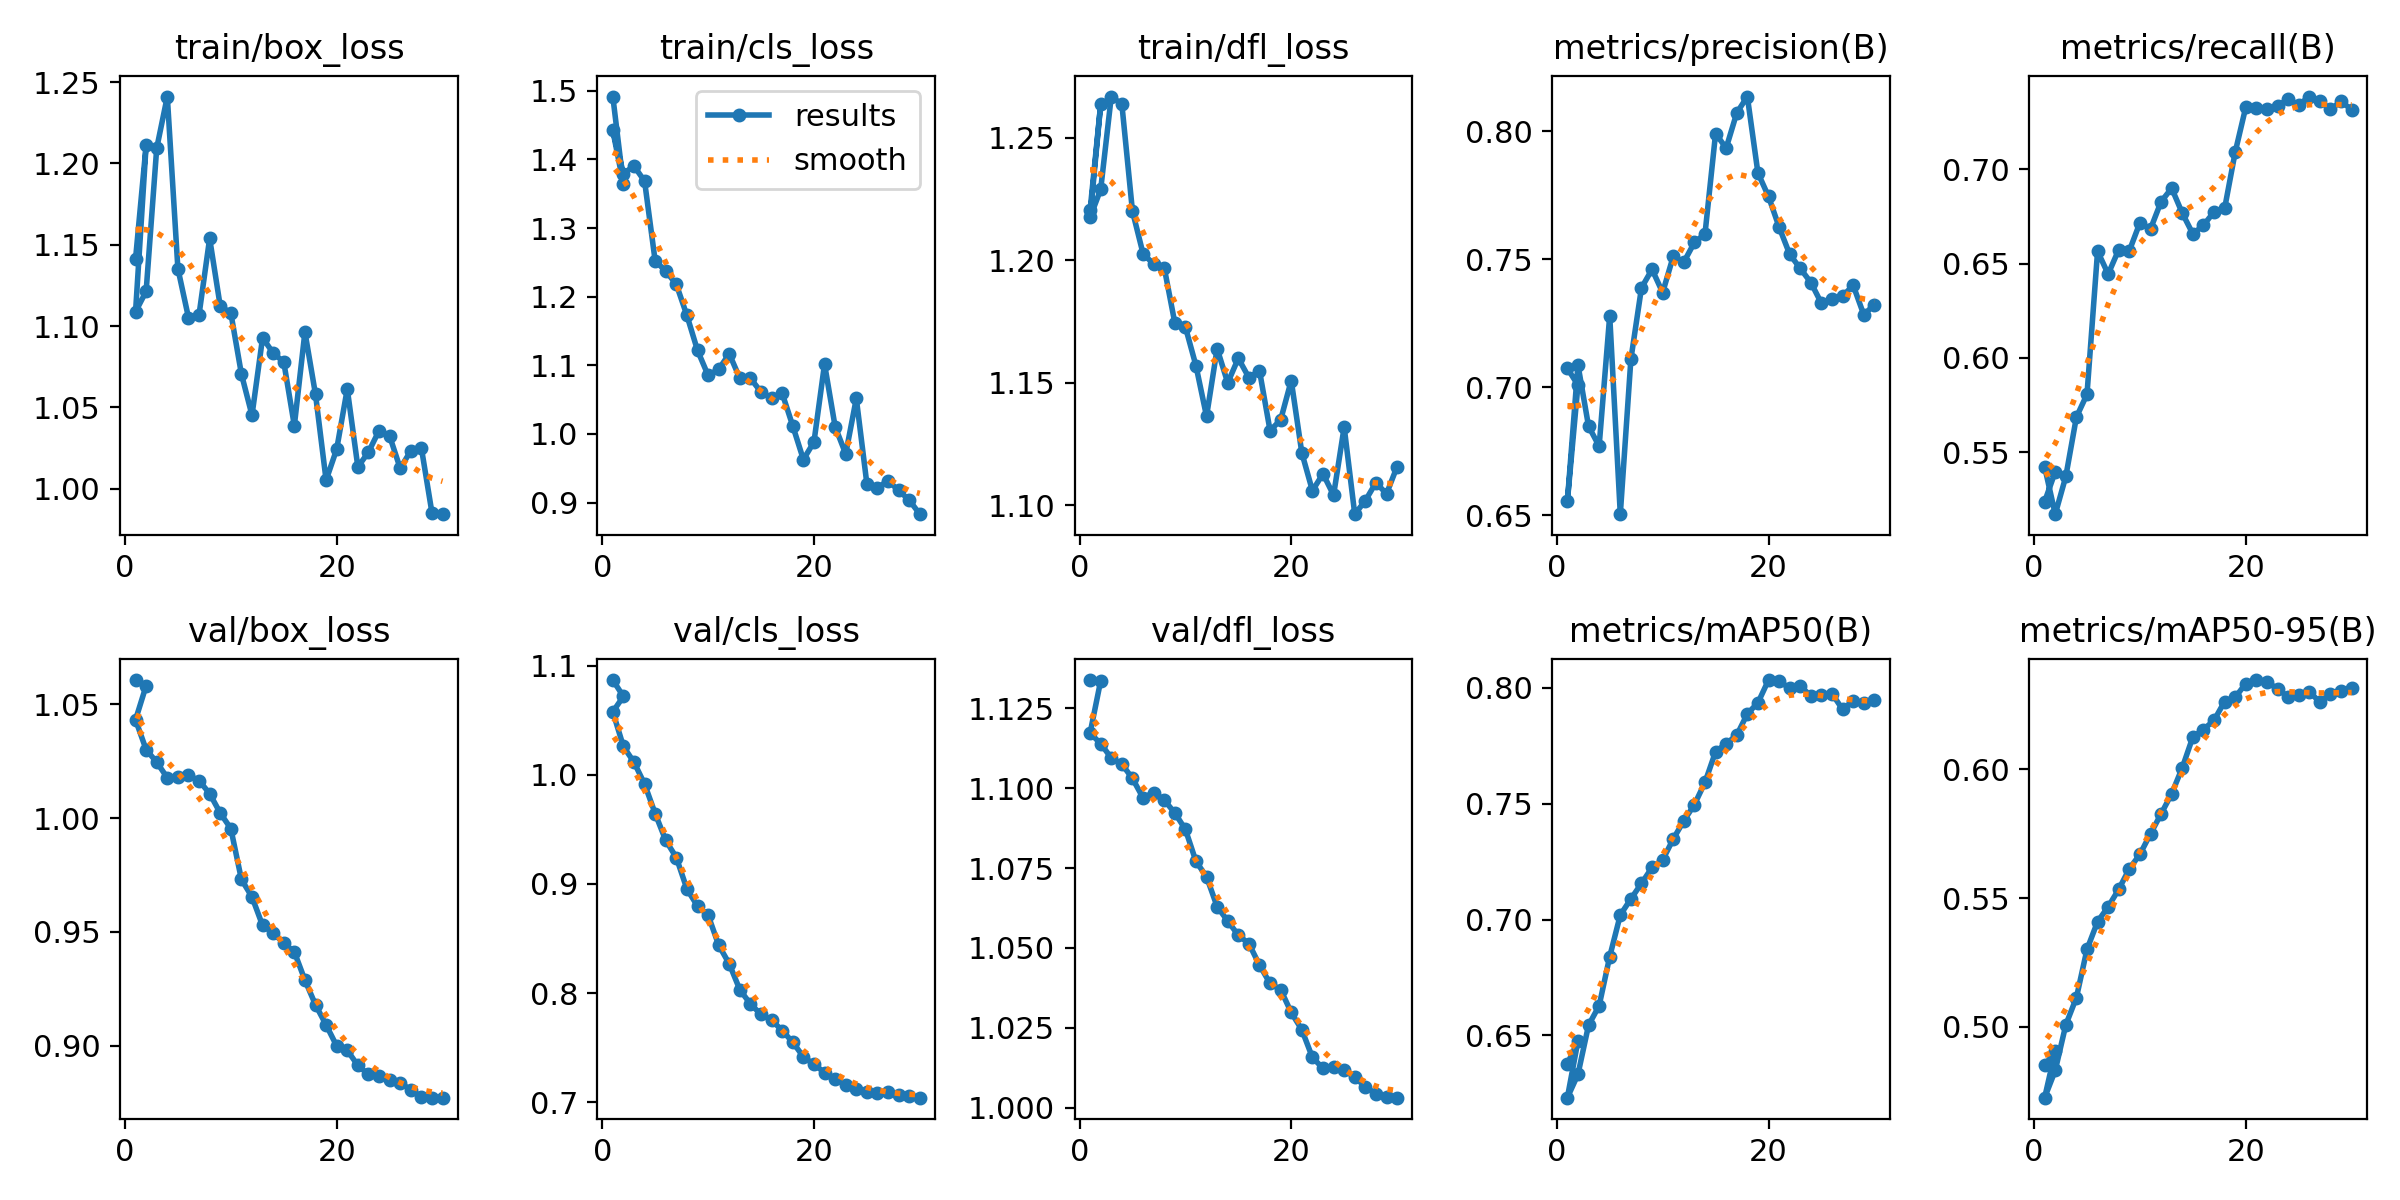

Confusion Matrix:


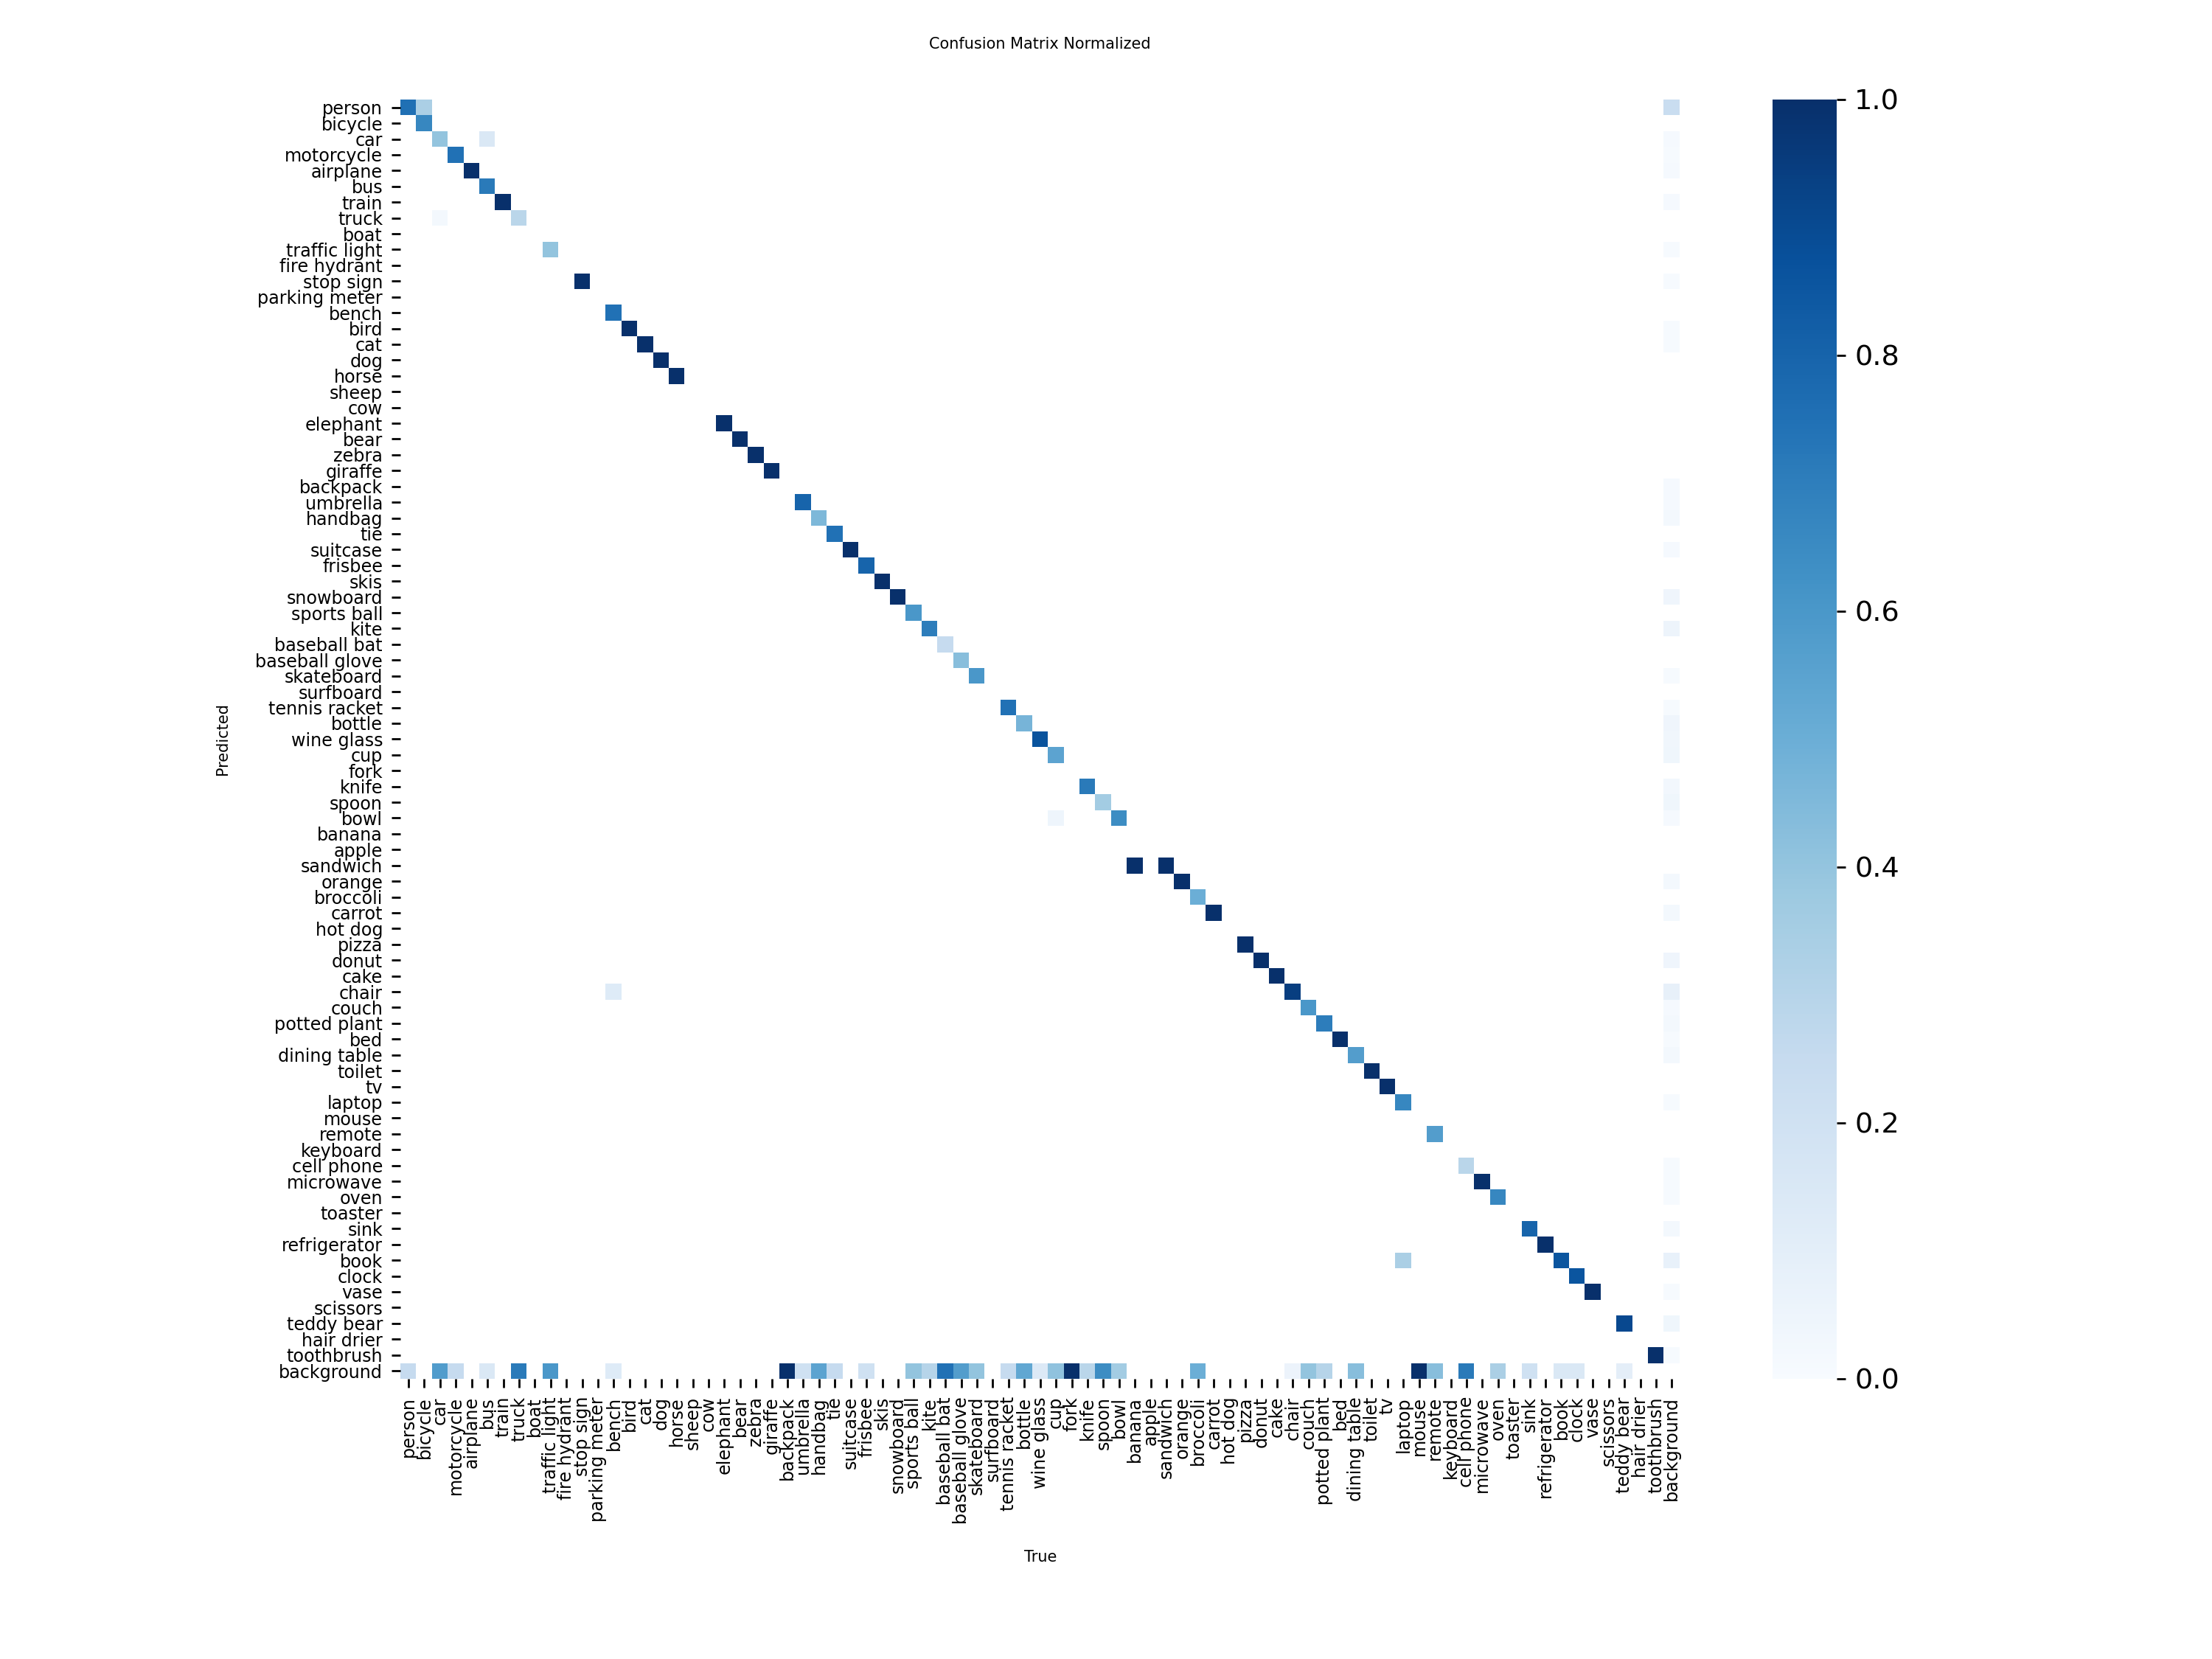

F1-Confidence Curve:


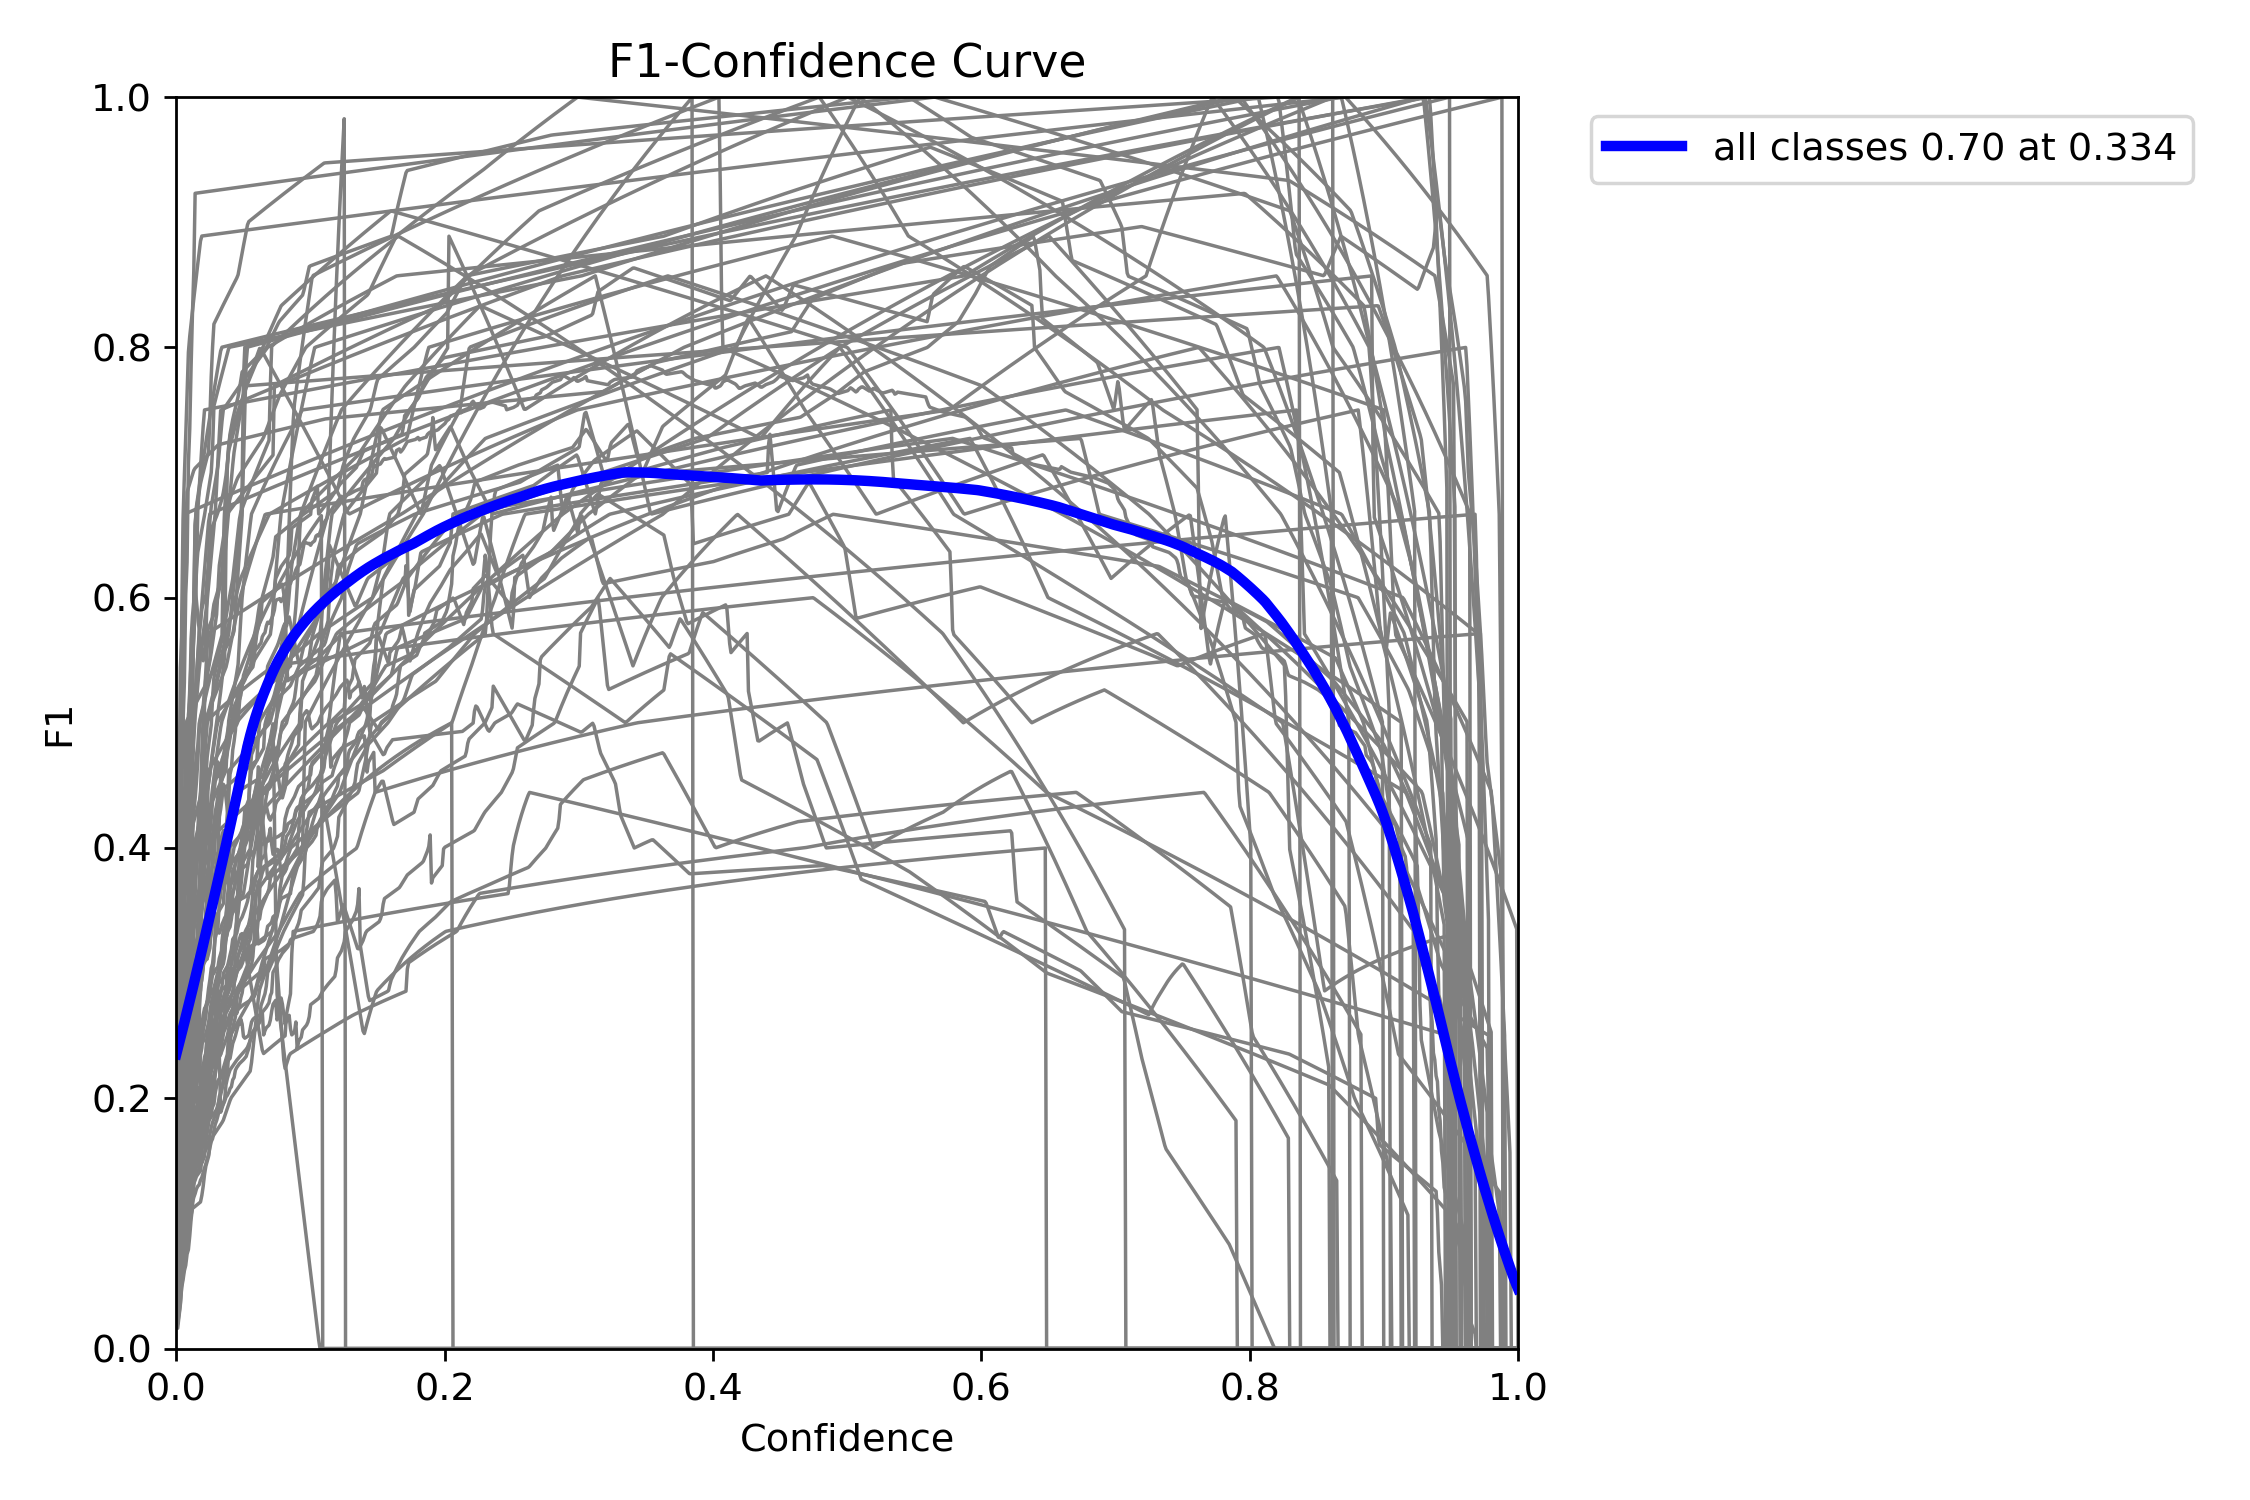

Precision-Recall Curve:


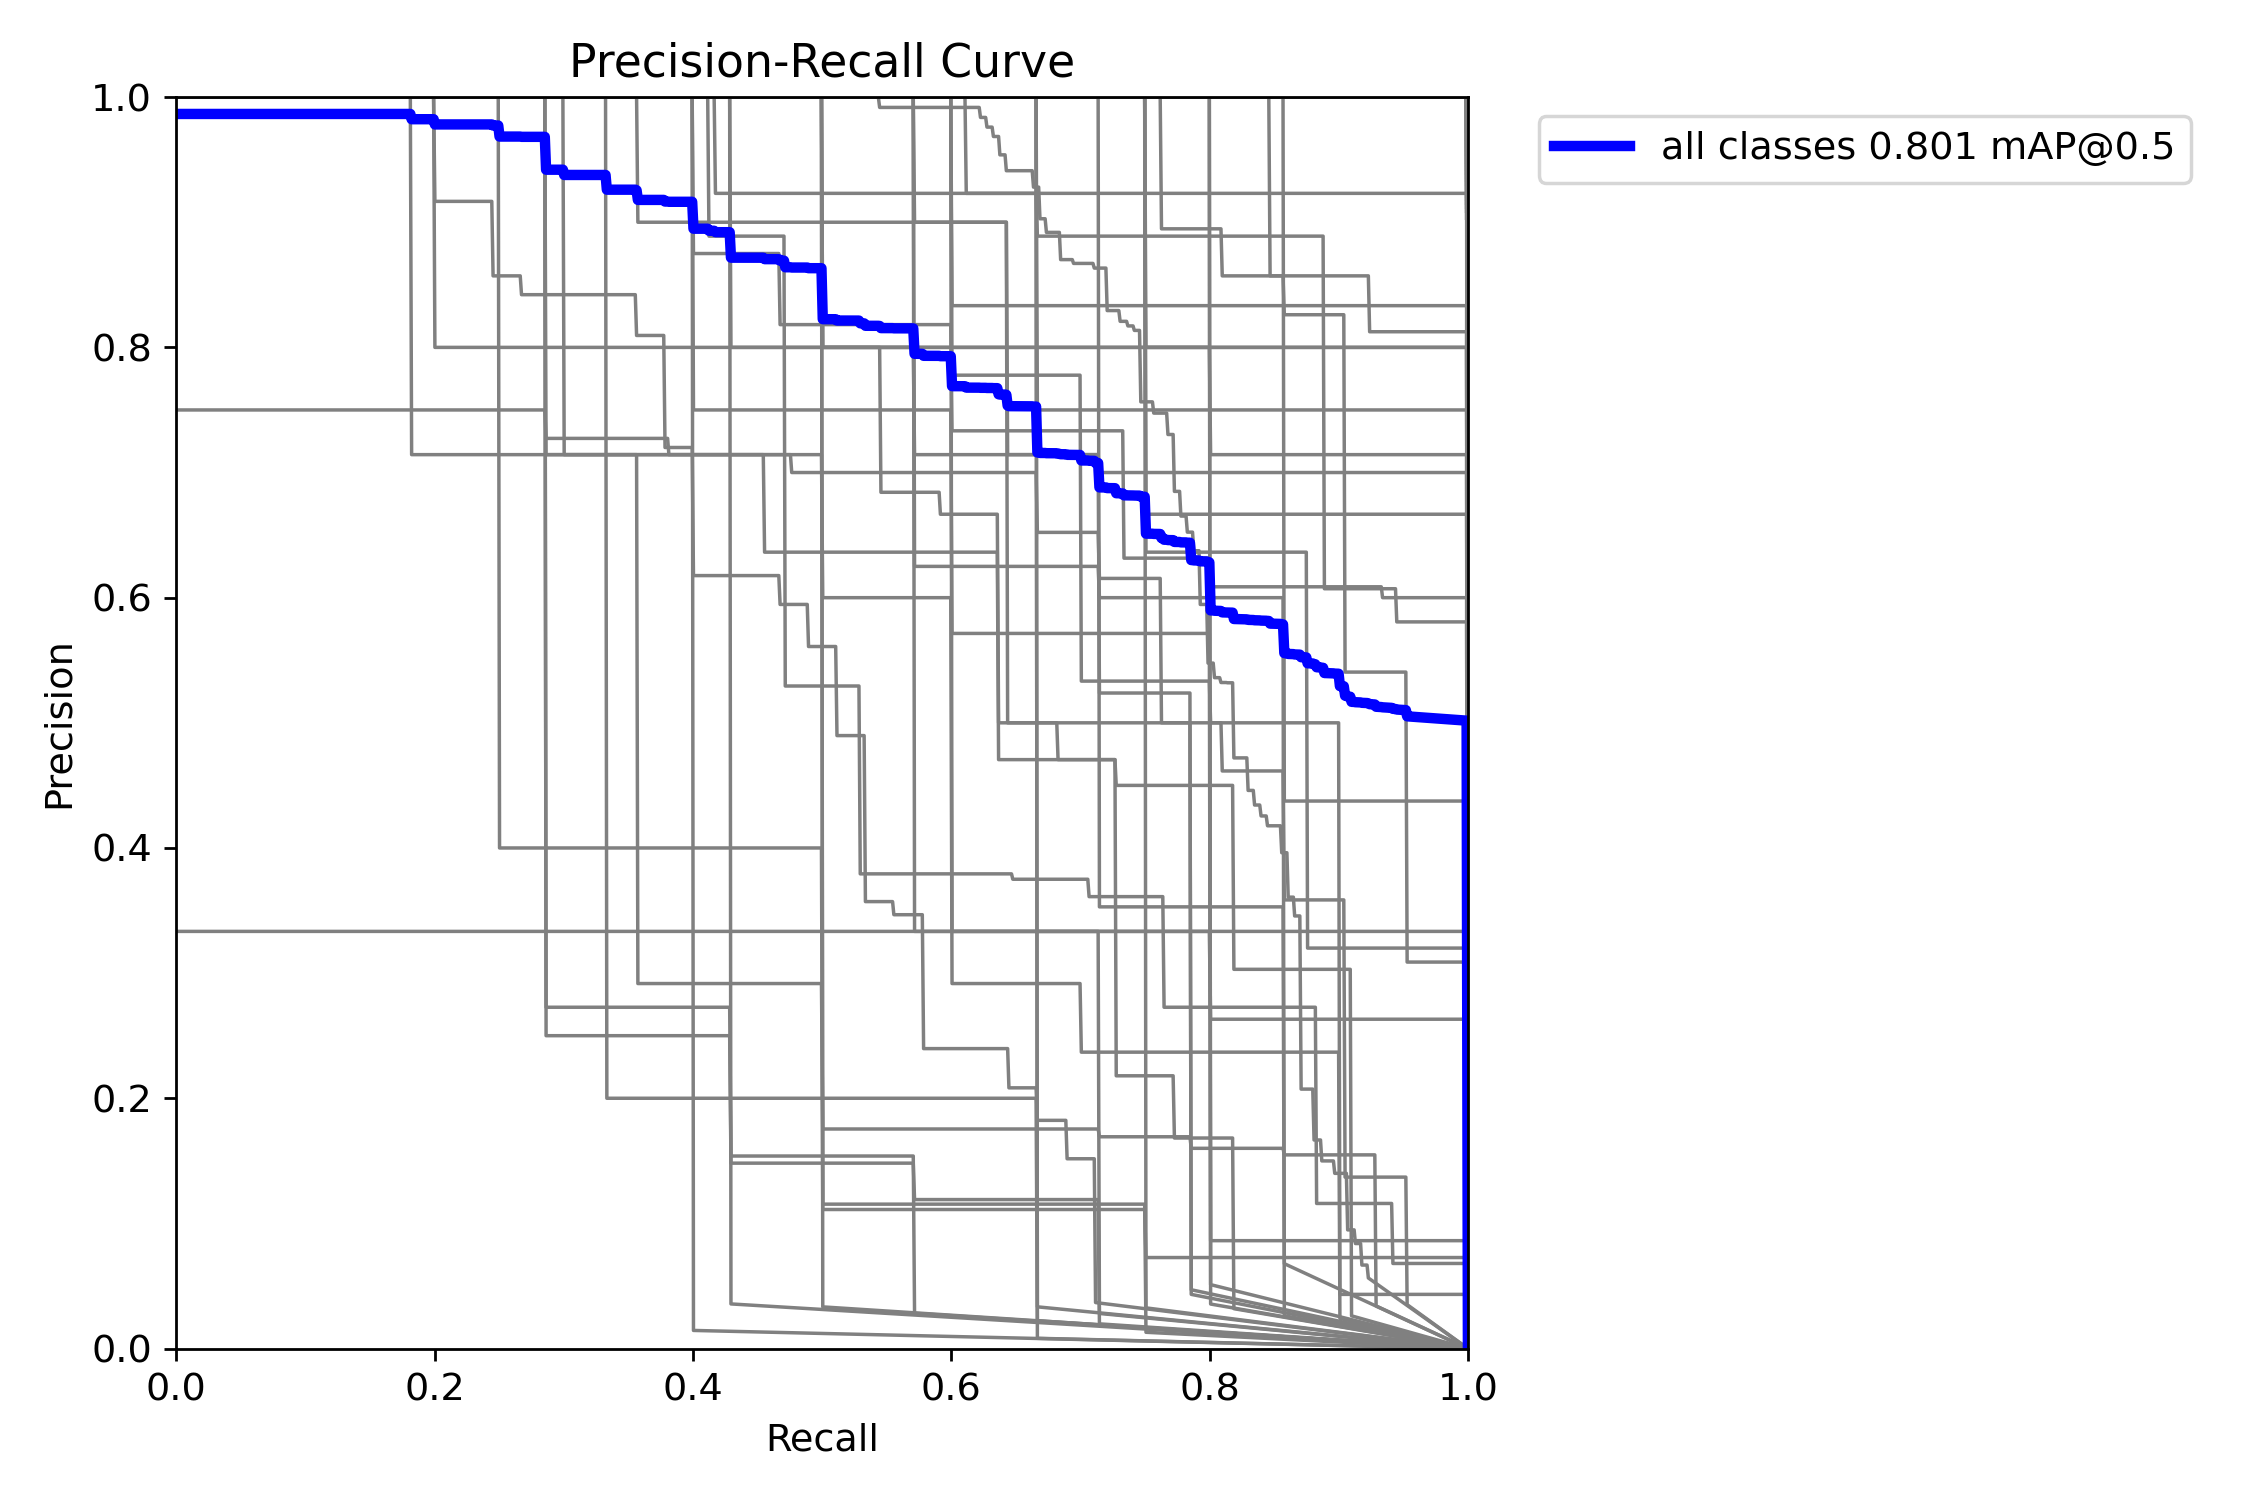

In [80]:
from IPython.display import Image, display
import os

# Path to the results directory
results_dir = f'/content/yolo_training_results/{run_version}'

# Display the training loss and metrics plots
print("Training Plots:")
display(Image(filename=os.path.join(results_dir, 'results.png')))

# Display the confusion matrix
print("Confusion Matrix:")
display(Image(filename=os.path.join(results_dir, 'confusion_matrix_normalized.png')))

# Display the F1-Confidence curve
print("F1-Confidence Curve:")
display(Image(filename=os.path.join(results_dir, 'BoxF1_curve.png')))

# Display the Precision-Recall curve
print("Precision-Recall Curve:")
display(Image(filename=os.path.join(results_dir, 'BoxPR_curve.png')))

results.png: This plot shows the training and validation loss curves (box, classification, and DFL loss) and key performance metrics (Precision, Recall, [redacted link], and [redacted link]:0.95) over the epochs.

Interpretation: You want to see the loss curves decrease over epochs, indicating the model is learning. The metrics curves (Precision, Recall, mAP) should generally increase, showing improved performance. Look for signs of overfitting (training loss continues to decrease, but validation loss and metrics plateau or worsen).

confusion_matrix.png: This matrix shows how many instances of each class were correctly or incorrectly identified.

Interpretation: The diagonal elements represent correct classifications (True Positives). Off-diagonal elements show misclassifications (e.g., predicting a "car" when it was a "truck"). A good model will have high values on the diagonal and low values elsewhere.

BoxPR_curve.png (Precision-Recall Curve): This plot shows the trade-off between precision and recall at different confidence thresholds for object detection bounding boxes.

Interpretation: A curve that is closer to the top-right corner indicates better performance. The Area Under the Curve (AUC) is related to the mAP metric.

BoxF1_curve.png (F1-Confidence Curve): This plot shows the F1 score (harmonic mean of precision and recall) at different confidence thresholds.

Interpretation: The peak of this curve indicates the confidence threshold that gives the best balance between precision and recall.

While BoxP_curve.png (Precision-Confidence) and BoxR_curve.png (Recall-Confidence) are also available, the F1-Confidence and Precision-Recall curves usually provide a more comprehensive view of the trade-off. The *_batch*.jpg images show examples of predictions on training and validation batches, which can be useful for visual inspection but are not quantitative performance metrics.

### side notes

based on the initial run with coco128, there is a large dataskew towards a single class, "person".

This can insentivies the model to guess towards person more often since it would be statistically correct more times than any other class.

to combat this, a couple of different tools can be used. Firstly increasing the data cohort will likely not change the data skew but will give the smaller groups more representation for the model to learn the inherent features of other classes.

Methods to adjust for the skew
- exclude the one problematic class (data loss and loss of ability to recognize "person")
- data augmentation ("create" more images of the other classes)
- apply weights to the classes

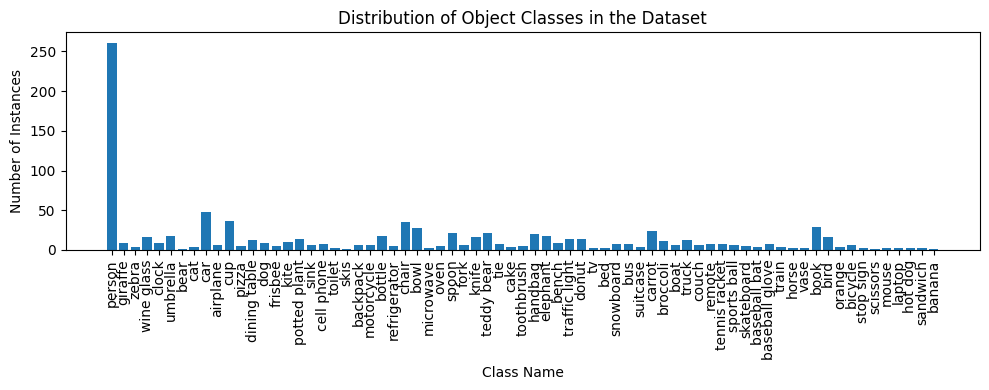


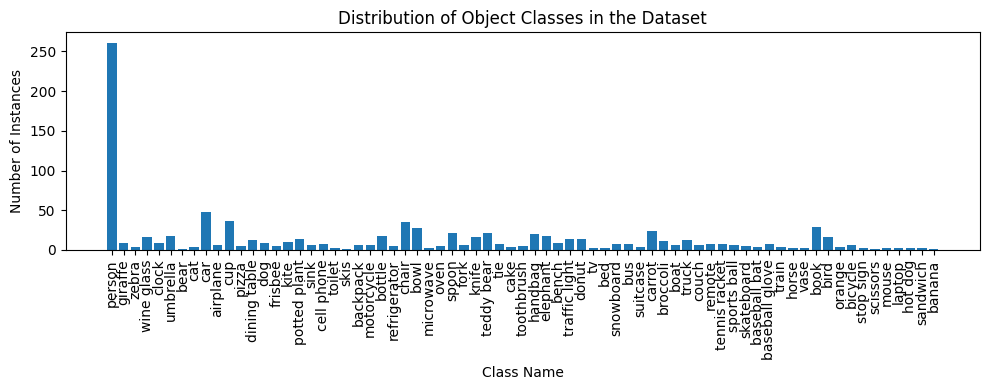

In [81]:
# code to genreate the histogram above. duplikatet to keep the first version if the cohort should change.

from collections import Counter

# Define the path to the labels
label_dir = '/content/coco128/labels/train2017'

# Get all label files
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

# Initialize a counter for class IDs
class_counts = Counter()

# Read each label file and count class IDs
for label_file in label_files:
    with open(os.path.join(label_dir, label_file), 'r') as f:
        for line in f:
            # The first number in each line is the class ID
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

# Get the class names from the configuration file
class_names = config['names']

# Create labels for the histogram using class names
histogram_labels = [class_names[class_id] for class_id in class_counts.keys()]
histogram_values = list(class_counts.values())

# Plot the histogram
plt.figure(figsize=(10, 4))
plt.bar(histogram_labels, histogram_values)
plt.xlabel('Class Name')
plt.ylabel('Number of Instances')
plt.title('Distribution of Object Classes in the Dataset')
plt.xticks(rotation=90) # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# Task
Load the trained YOLO model, sample 5 images from the validation set, run inference on these images, and visualize the predictions with bounding boxes and labels.

## Load trained model

### Subtask:
Load the trained YOLO model.


**Reasoning**:
Import the YOLO class and load the trained model weights from the results directory.



In [82]:
from ultralytics import YOLO
import os

# Path to the results directory from training
results_dir = f'/content/yolo_training_results/{run_version}'

# Define the path to the trained model weights
# Check if 'best.pt' exists, otherwise use 'last.pt'
model_path_best = os.path.join(results_dir, 'weights', 'best.pt')
model_path_last = os.path.join(results_dir, 'weights', 'last.pt')

if os.path.exists(model_path_best):
    model_path = model_path_best
    print("Loading best.pt model weights.")
elif os.path.exists(model_path_last):
    model_path = model_path_last
    print("Loading last.pt model weights.")
else:
    model_path = None
    print("No trained model weights found.")


# Load the trained YOLO model
if model_path:
    trained_model = YOLO(model_path)
    print("Trained model loaded successfully.")
else:
    print("Failed to load trained model.")


Loading best.pt model weights.
Trained model loaded successfully.


## Select sample images

### Subtask:
Randomly select 5 images from the validation set.


**Reasoning**:
List the image files in the validation directory and randomly select 5 of them for inference.



In [83]:
import random
import os

# List all image files in the validation directory
val_image_dir = '/content/coco128_split/images/val2017'
val_image_files = [f for f in os.listdir(val_image_dir) if f.endswith('.jpg')]

# Check if there are enough images
num_images_to_select = 5
if len(val_image_files) < num_images_to_select:
    selected_image_files = val_image_files
    print(f"Warning: Only {len(val_image_files)} images found in the validation directory. Selecting all available images.")
else:
    # Randomly select 5 image filenames
    selected_image_files = random.sample(val_image_files, num_images_to_select)

print(f"Selected images for inference: {selected_image_files}")

Selected images for inference: ['000000000490.jpg', '000000000241.jpg', '000000000488.jpg', '000000000486.jpg', '000000000569.jpg']


## Run inference

### Subtask:
Run the trained model on the selected images to get predictions.


**Reasoning**:
Iterate through the selected image files and run inference using the trained model.



In [84]:
# List to store inference results for each image
inference_results = []

# Iterate through the selected image files
for image_file in selected_image_files:
    # Construct the full path to the image
    image_path = os.path.join(val_image_dir, image_file)

    # Run inference on the image
    results = trained_model.predict(image_path)

    # Store the results for this image
    inference_results.append(results)

print(f"Inference completed for {len(inference_results)} images.")


image 1/1 /content/coco128_split/images/val2017/000000000490.jpg: 640x640 1 dog, 1 skateboard, 303.5ms
Speed: 5.4ms preprocess, 303.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/coco128_split/images/val2017/000000000241.jpg: 640x480 6 persons, 1 backpack, 2 handbags, 1 bottle, 2 cups, 2 couchs, 1 potted plant, 1 remote, 220.3ms
Speed: 2.3ms preprocess, 220.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/coco128_split/images/val2017/000000000488.jpg: 416x640 5 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 195.6ms
Speed: 2.8ms preprocess, 195.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/coco128_split/images/val2017/000000000486.jpg: 448x640 1 bowl, 1 microwave, 1 oven, 1 refrigerator, 213.9ms
Speed: 3.0ms preprocess, 213.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/coco128_split/images/val2017/000000000569

**Reasoning**:
The variable `trained_model` was not defined in the current session. The previous code block to load the model needs to be rerun to define the variable.



In [85]:
# Path to the results directory from training
results_dir = f'/content/yolo_training_results/{run_version}'

# Define the path to the trained model weights
# Check if 'best.pt' exists, otherwise use 'last.pt'
model_path_best = os.path.join(results_dir, 'weights', 'best.pt')
model_path_last = os.path.join(results_dir, 'weights', 'last.pt')

if os.path.exists(model_path_best):
    model_path = model_path_best
    print("Loading best.pt model weights.")
elif os.path.exists(model_path_last):
    model_path = model_path_last
    print("Loading last.pt model weights.")
else:
    model_path = None
    print("No trained model weights found.")


# Load the trained YOLO model
if model_path:
    trained_model = YOLO(model_path)
    print("Trained model loaded successfully.")
else:
    print("Failed to load trained model.")

# List to store inference results for each image
inference_results = []

# Iterate through the selected image files
for image_file in selected_image_files:
    # Construct the full path to the image
    image_path = os.path.join(val_image_dir, image_file)

    # Run inference on the image
    results = trained_model.predict(image_path)

    # Store the results for this image
    inference_results.append(results)

print(f"Inference completed for {len(inference_results)} images.")

Loading best.pt model weights.
Trained model loaded successfully.

image 1/1 /content/coco128_split/images/val2017/000000000490.jpg: 640x640 1 dog, 1 skateboard, 257.5ms
Speed: 4.4ms preprocess, 257.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/coco128_split/images/val2017/000000000241.jpg: 640x480 6 persons, 1 backpack, 2 handbags, 1 bottle, 2 cups, 2 couchs, 1 potted plant, 1 remote, 200.9ms
Speed: 2.9ms preprocess, 200.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/coco128_split/images/val2017/000000000488.jpg: 416x640 5 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 172.0ms
Speed: 2.9ms preprocess, 172.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/coco128_split/images/val2017/000000000486.jpg: 448x640 1 bowl, 1 microwave, 1 oven, 1 refrigerator, 200.6ms
Speed: 2.2ms preprocess, 200.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 

## Visualize predictions

### Subtask:
Display the images with the predicted bounding boxes and labels.


**Reasoning**:
Iterate through the inference results and display each image with predicted bounding boxes and labels.



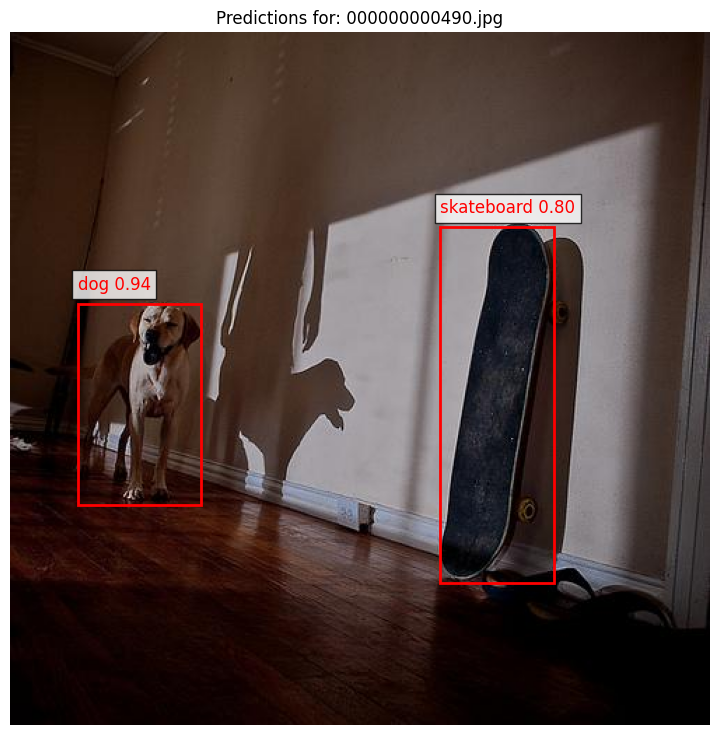

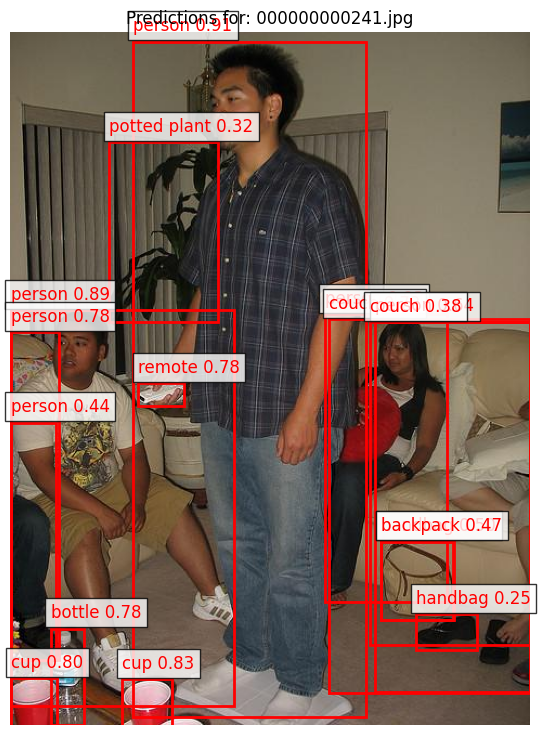

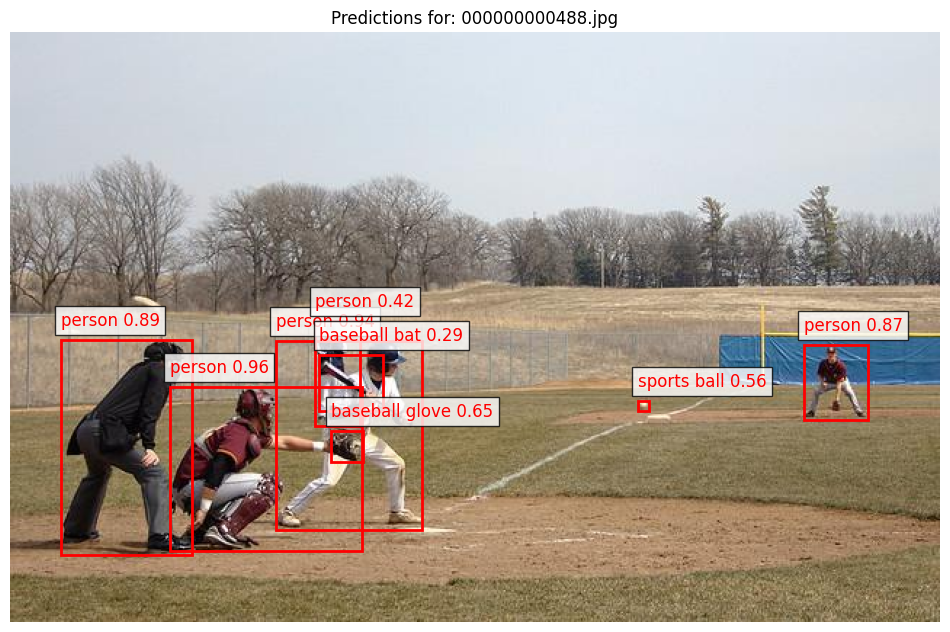

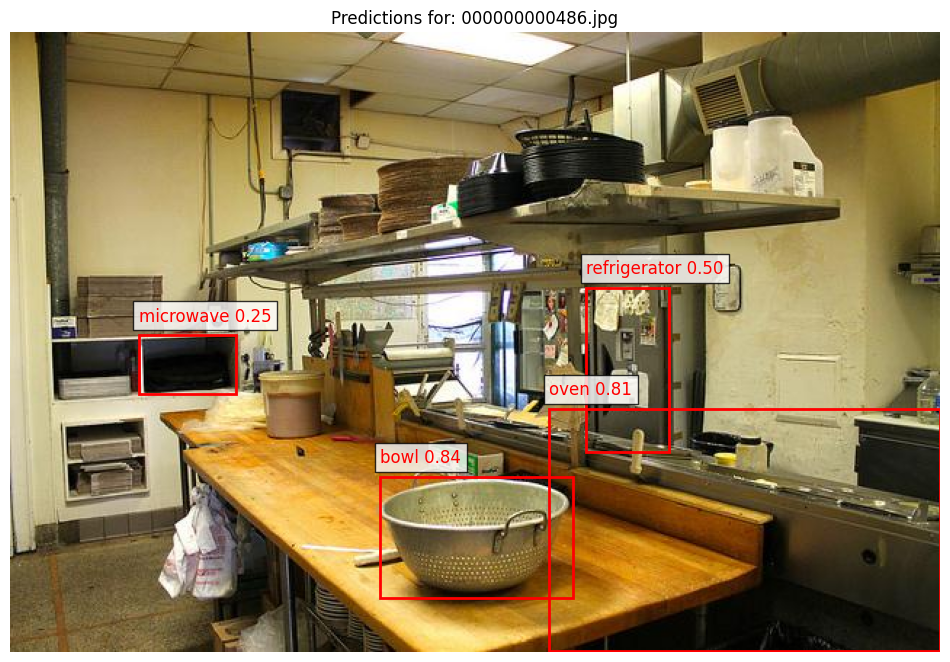

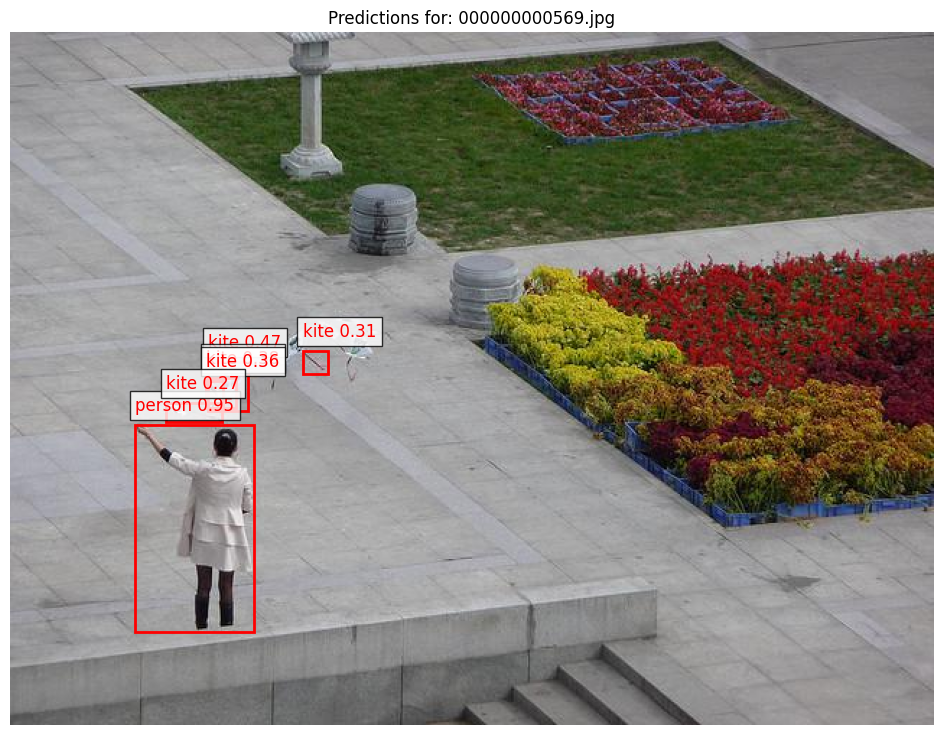

In [86]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# Iterate through the inference results list
for results in inference_results:
    # Extract image path and detections from the results
    # The results object from model.predict is typically a list of Results objects
    # For a single image prediction, results will be a list containing one Results object
    result = results[0] # Get the single Results object for the image

    # Get the image path from the results object
    image_path = result.path
    img = Image.open(image_path)

    # Display the image
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)

    # Iterate through the detected objects
    for box in result.boxes:
        # Extract bounding box coordinates (xyxy format)
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        confidence = box.conf[0].item()
        class_id = int(box.cls[0].item())
        class_name = trained_model.names[class_id]

        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add class label and confidence score
        label = f'{class_name} {confidence:.2f}'
        plt.text(x1, y1 - 10, label, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # Set title and hide axes
    ax.set_title(f"Predictions for: {os.path.basename(image_path)}")
    ax.axis('off')

    # Show the plot
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The trained YOLO model was successfully loaded, either using `best.pt` or `last.pt` weight files.
*   Five image filenames were randomly selected from the validation set directory `/content/coco128_split/images/val2017`.
*   Inference was performed on the 5 selected validation images using the loaded YOLO model.
*   The prediction results for each image, including bounding box coordinates, confidence scores, and class IDs, were successfully retrieved.
*   The selected images were displayed with the predicted bounding boxes, class labels, and confidence scores overlaid using matplotlib.

### Insights or Next Steps

*   The visualization provides a qualitative assessment of the model's performance on individual images, highlighting where it makes correct or incorrect predictions.
*   Quantitatively evaluate the model's performance on the full validation set using standard object detection metrics (e.g., mAP, precision, recall) to get a comprehensive understanding of its accuracy.


## Run inference on your own image

### Subtask:
Upload an image and run inference using the trained model.

Saving jackie_og_malthe.jpg to jackie_og_malthe.jpg
Running inference on jackie_og_malthe.jpg...

image 1/1 /content/jackie_og_malthe.jpg: 480x640 1 person, 1 dog, 2 beds, 1 book, 528.4ms
Speed: 7.6ms preprocess, 528.4ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)
Displaying predictions...


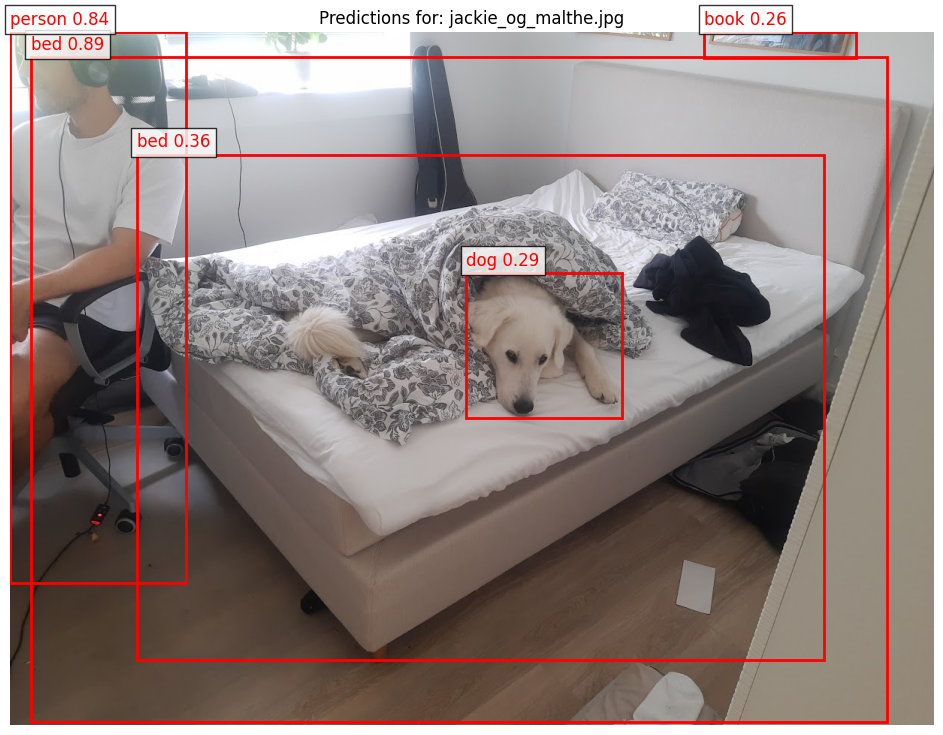

In [87]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

# Upload your image file
uploaded = files.upload()

# Assuming you upload one image, get its filename
image_filename = next(iter(uploaded))
image_path = os.path.join('/content/', image_filename)

# Check if the trained_model variable is defined
if 'trained_model' not in locals():
    print("Error: Trained model not loaded. Please run the 'Load trained model' cell first.")
else:
    # Run inference on the uploaded image
    print(f"Running inference on {image_filename}...")
    results = trained_model.predict(image_path)

    # Display the image with predictions
    print("Displaying predictions...")
    for result in results:
        img = Image.open(result.path)
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(img)

        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            class_id = int(box.cls[0].item())
            class_name = trained_model.names[class_id]

            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            label = f'{class_name} {confidence:.2f}'
            plt.text(x1, y1 - 10, label, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

        ax.set_title(f"Predictions for: {os.path.basename(image_path)}")
        ax.axis('off')
        plt.show()